LNK02 based on Spike Feedback Model from Leo by adding nonlinearity and kinetic model after filter output

Update history: Dec 25, 2021 created by ckc

Ozuysal, Y. and S. A. Baccus (2012). "Linking the Computational Structure of Variance Adaptation to Biophysical Mechanisms." Neuron 73(5): 1002-1015.

# Import and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import ndimage
import pandas as pd
import os
import math


%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('Modules')
except:
    try:
        os.chdir("..\\Modules")
    except:
        print('Cannot find in ..\Modules')
#finally:
#    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\retina_python\\Modules')
    
from time_shifted_PID import MIfunc
from time_shifted_PID import EqualState
# from StimulusnResponse import SSG
from Spike_Generation import SG
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb


In [3]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50], z[:len(T):50]

In [4]:
# using numpy's histogram2d to calculate the mutual information between two sequences
def mi_quick(a,b,d,bn=25):
    if d>0: xy,_,_ = np.histogram2d(a[d:],b[:-d],bn)
    elif d<0: xy,_,_ = np.histogram2d(a[:d],b[-d:],bn)
    else: xy,_,_ = np.histogram2d(a,b,bn)
    xy /= np.sum(xy)
    px = [np.array([max(x,1e-100) for x in np.sum(xy,axis=0)])]
    py = np.transpose([[max(x,1e-100) for x in np.sum(xy,axis=1)]])
    nxy = (xy/px)/py
    nxy[nxy==0] = 1e-100
    return np.sum(xy*np.log2(nxy))

In [5]:
# nonlinear function
def NL(x,midpoint):
    tmp = []
    for i in range(len(x)):
        tmp.append((math.tanh((x[i]-midpoint)*10.)+1)/2)              
    return(tmp)

In [6]:
# four states kinetic model
# using the same notation as Ozuysal
# Eqn(11) in "Experimental Procedure" section

def kinetic(u,para,dt):
    ka  = para[0]
    kfr = para[1]
    kfi = para[2]
    ksr = para[3]
    ksi = para[4]
#   initial conditions for the four states
    p1 = 1.0
    p2 = 0
    p3 = 0.0
    p4 = 0.0

    p1r = []
    p2r = []
    p3r = []
    p4r = []
#
# 
#
    for i in range(len(u)):
        dp1 = (-u[i]*ka*p1  + kfr*p3)*dt
        dp2 =  (u[i]*ka*p1     - kfi*p2)*dt
        dp3 =  (kfi*p2 - (kfr+ksi)*p3 + u[i]*ksr*p4)*dt
        dp4 =  (ksi*p3 - u[i]*ksr*p4)*dt
    
        p1 = p1 + dp1
        p2 = p2 + dp2
        p3 = p3 + dp3
        p4 = p4 + dp4
    
        p1r.append(p1)
        p2r.append(p2)
        p3r.append(p3)
        p4r.append(p4)
        
# turn list into numpy arrays
    p1r = np.array(p1r)
    p2r = np.array(p2r)
    p3r = np.array(p3r)
    p4r = np.array(p4r)
    return(p1r,p2r,p3r,p4r)

# Set Parameter

In [7]:
m = 16.416565
n =	500
alpha = 41.464099
beta = 2.088120
g =  1729.111153/n
tau_y = 0.051583

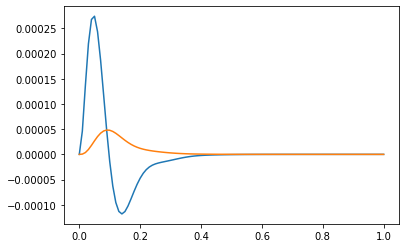

In [8]:
dt = 0.01
TKaxis = np.arange(101)*dt

k_E, k_S = NGD_TK(TKaxis, m, n, alpha, beta, g, tau_y)
# y_TK, w_TK = NGD_TK(TKaxis, *[2.67758918, 1.00000000, 1.17089092e+01, 4.69398540, 4.73653606e+02, 2.45547756e-02])
plt.plot(TKaxis, k_E)
plt.plot(TKaxis, k_S)

In [9]:
tot = 300+100 # added 100 seconds for transience
tAxis = np.arange(0,tot,dt)
# OU ; input
tau = 1
D = 1
OU=np.zeros(len(tAxis))
mu, sigma = 0, 1
for i in range(len(tAxis)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)
x = (LPOU-np.mean(LPOU))/np.std(LPOU)

In [10]:
amp = 2
mean = 10
baseOutput = np.convolve(np.hstack((np.zeros(len(k_E)), x)), -k_E, 'full')[len(k_E):len(k_E)+len(x)]

(0.0, 5000.0)

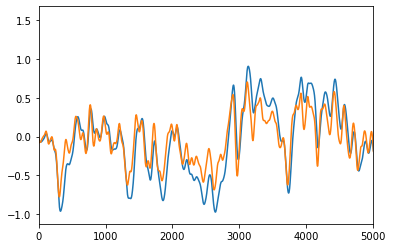

In [11]:
#Using notation of: J Neurophysiol 98: 1287–1296, 2007.
#Contrast Adaptation in a Nonadapting LGN Model
#Kate S. Gaudry and Pamela Reinagel

s = x.copy()/x.max()
g = baseOutput.copy()/baseOutput.max()

plt.plot(-s)
plt.plot(g)
plt.xlim(0,5000)

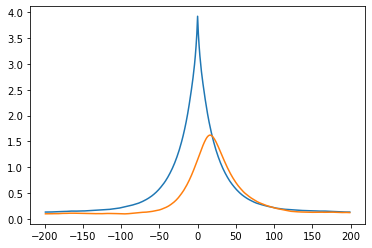

In [12]:
dms = range(-199,200)
mi_ss = [mi_quick(s,s,d) for d in dms]
mi_sg = [mi_quick(s,g,d) for d in dms]
plt.plot(dms,mi_ss)
plt.plot(dms,np.array(mi_sg))

In [13]:
print('Anticipation horizon =',dms[np.argmax(mi_sg)]*dt,'second')

Anticipation horizon = 0.16 second


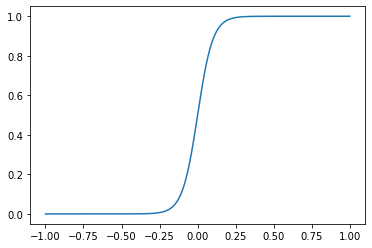

In [14]:
# Nonlinearity function
midpoint = 0.0 #position of the mid point of the nonlinear function (tanh)
dummy = np.linspace(-1,1,1000)
plt.plot(dummy,NL(dummy,midpoint))

(0.0, 5000.0)

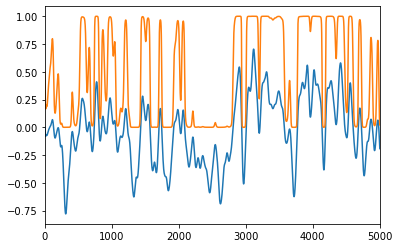

In [15]:
# testing of u from g
u = NL(g,0.0)
plt.plot(g)
plt.plot(u)
plt.xlim(0,5000)

[1. 1. 1. ... 1. 1. 1.]


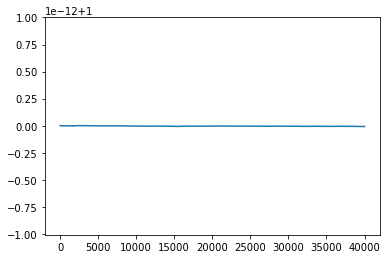

In [16]:
# using the same notation as Ozuysal 

para = [60,20,3,0.03,1.0] # parameters for the five rates from Figure 2
midpoint= 0.0 # this is similar to the threshold of Leo's code?

u = NL(g,midpoint)
R,A,I1,I2=kinetic(u,para,dt)

# checking if the sum of the pools are conserved.
plt.plot(R+A+I1+I2)
print(R+A+I1+I2)

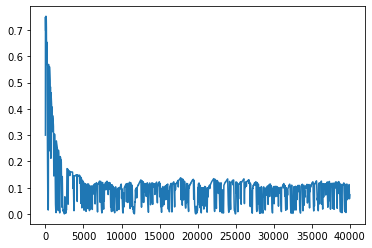

In [17]:
# Action pool = output of the system
plt.plot(A)

(0.0, 10000.0)

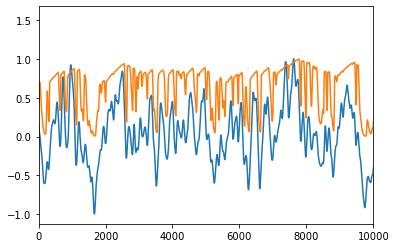

In [18]:
# remove the first 10000 (10 sec) points for transients
ss = x[10000:]
rr = A[10000:]
plt.plot(-ss/ss.max())
plt.plot(rr/rr.max())
plt.xlim(0,10000)

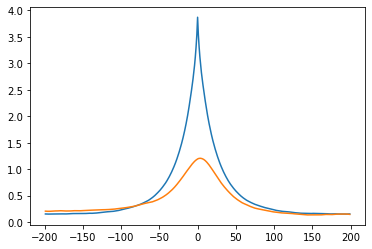

In [19]:
# check if there is anticipation by TLMI

dms = range(-199,200)
mi_ssss = [mi_quick(ss,ss,d) for d in dms]
mi_ssrr = [mi_quick(ss,rr,d) for d in dms]
plt.plot(dms,mi_ssss)
plt.plot(dms,np.array(mi_ssrr))

In [20]:
print('Anticipation horizon =',dms[np.argmax(mi_ssrr)]*dt,'second')

Anticipation horizon = 0.03 second
